# Estrategia de Cero Pérdidas :) 
El Mejor Indicador de Scalping en Tradingview ( Parecen Hacks ) \
https://www.youtube.com/watch?v=4B9_nRCOar0

In [24]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from datetime import timedelta

import os
import pickle
from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
import scripts.functions as fn 
from scripts.indicators import resample, join_after_resample, ITG_Scalper, Edri_Extreme_Points_Buy_Sell

C:\Users\lbisa\Mi unidad (leonardo.bisaro@gmail.com)\Cripto\python\trd_app


In [25]:
#klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/0m05/Lateral_BTCUSDT_0m05_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/0m15/Lateral_BTCUSDT_0m15_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/2d01/Lateral_BTCUSDT_2d01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Lateral_BTCUSDT_1h01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'

#klines_file = './backtest/klines/1h04/Bajista_BTCUSDT_1h04_2021-04-12_2021-07-12.DataFrame'
with open(klines_file, 'rb') as file:
    df = pickle.load(file)
    #data.set_index('datetime',inplace=True)


## ITG_Scalper

<Axes: >

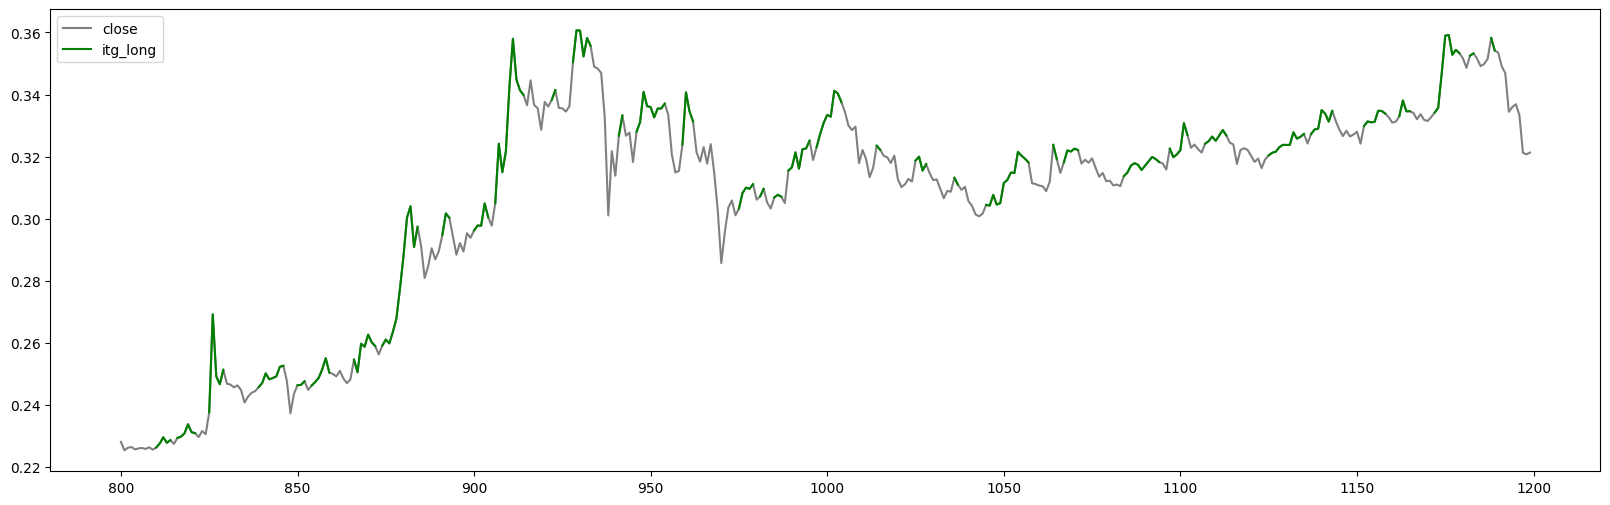

In [26]:
df = ITG_Scalper(df)
#add columns:  'long', 'short','buy_alert', 'sell_alert'
df['itg_long'] = np.where((df['long']),df['close'],None)
df['itg_short'] = np.where((df['short']),df['close'],None)
df[['close','itg_long']][800:1200].plot(figsize=(20,6),style=['gray','green'])


# Edri_Extreme_Points_Buy_Sell 

<Axes: >

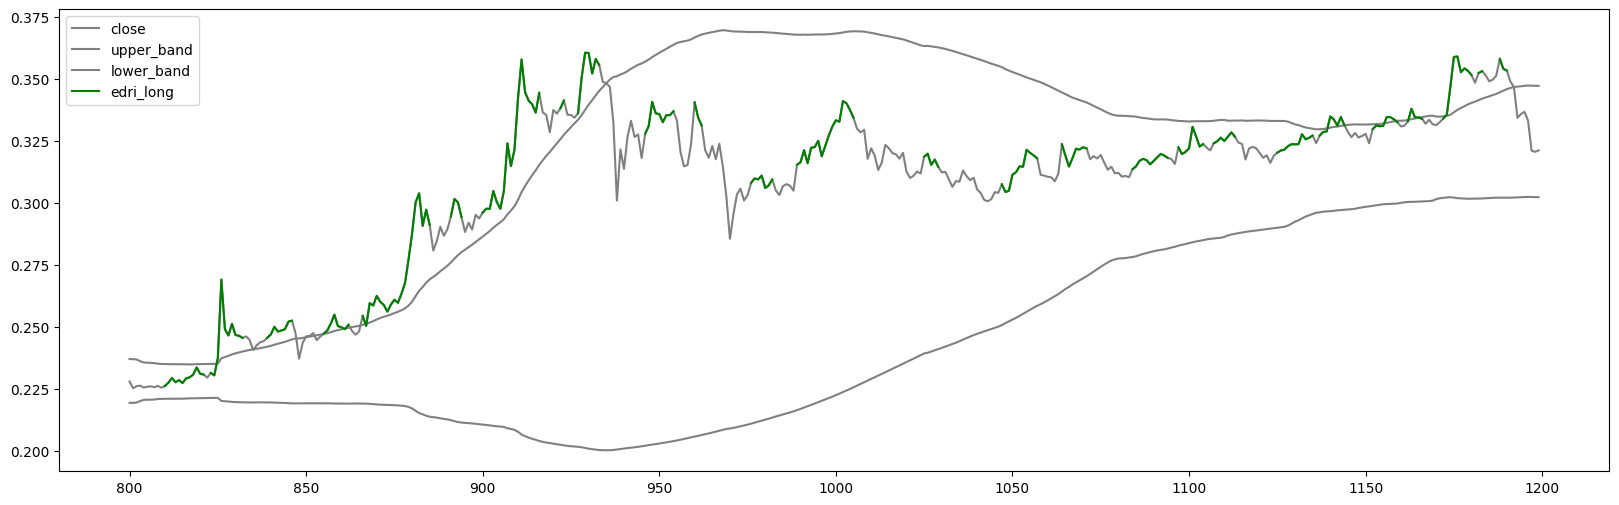

In [37]:



df = Edri_Extreme_Points_Buy_Sell(df)
df['edri_long'] = np.where((df['long_entry']),df['close'],None)
df['edri_short'] = np.where((df['short_entry']),df['close'],None)

df[['close','upper_band','lower_band','edri_long']][800:1200].plot(figsize=(20,6),style=['gray','gray','gray','green'])


# RSI 
21 periodos y un timeframe x4 (Timeframe original 15m x4 = 1H)


<Axes: >

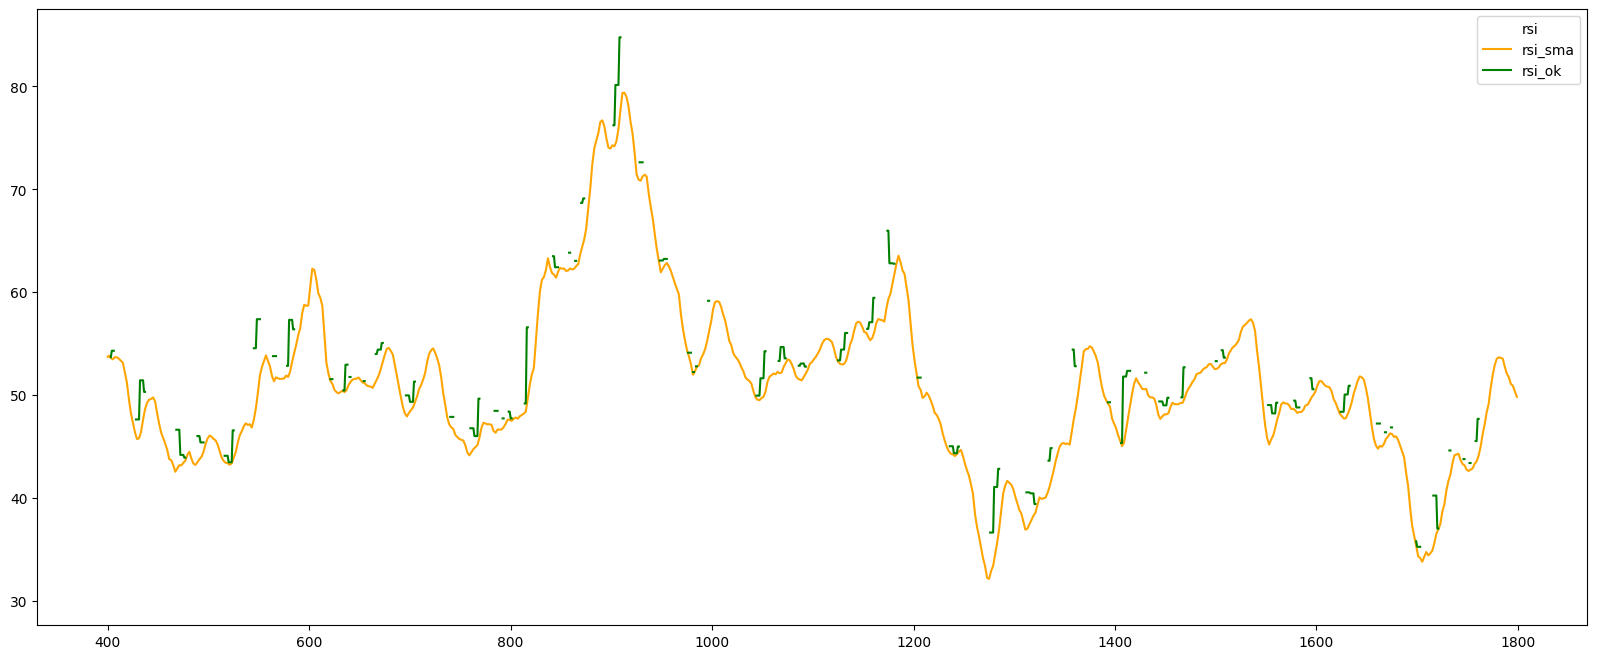

In [38]:


dfx4 = resample(df,4)

rsi_x4 = ta.rsi(dfx4['close'], length=21)

df = join_after_resample(df,rsi_x4,'rsi')

df['rsi_sma'] = df['rsi'].rolling(14).mean()

df['rsi_ok'] = np.where((df['rsi']>df['rsi_sma'])&(df['rsi'].shift(10)<df['rsi_sma'].shift(10)),df['rsi'],None)
df[['rsi','rsi_sma','rsi_ok']][400:1800].plot(figsize=(20,8),style=['w--','orange','green'])

<Axes: >

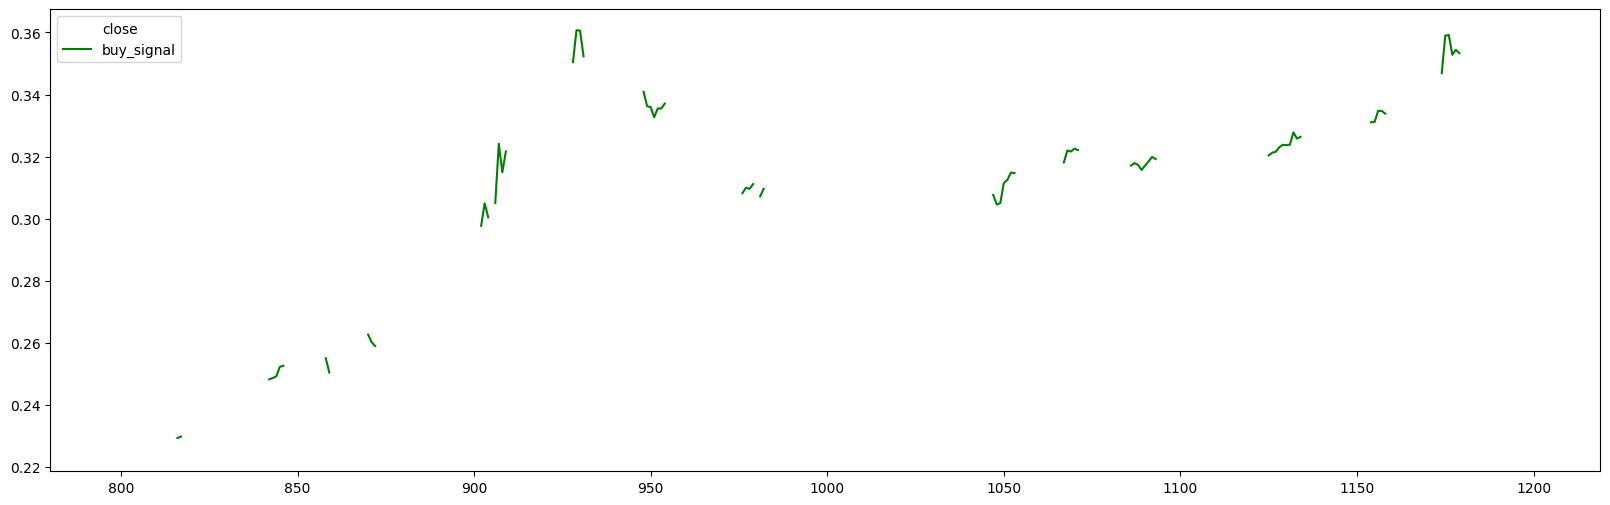

In [41]:
df['buy_signal'] = np.where(((df['itg_long']>0)&(df['rsi_ok']>0))&(df['edri_long']>0),df['close'],None)
df[['close','buy_signal']][800:1200].plot(figsize=(20,6),style=['white','green'])

In [30]:
max = 0
min = 0
buy = 0

ops = []
range = 21*4
for i in df.index:
    if i>range:
        tmp_df = df[(i-range):i]
        row = df.loc[i]
        if row['buy_signal'] and row['buy_signal']>0:
            if buy > 0:
                mef = round(((max/buy)-1)*100,2)
                mea = round(((min/buy)-1)*100,2)
                pos = 1 if abs(mef) > abs(mea) else 0
                neg = 1 if abs(mef) < abs(mea) else 0
                ops.append({'buy':buy, 'mea': abs(mea), 'mef': abs(mef), 'pos': pos, 'neg': neg})
            buy = row['close']
            max = buy
            min = buy
        
        if buy>0:
            if row['high']>max:
                max = row['high']
            if row['low']<min:
                min = row['low']
#ultimo registro
if buy > 0:
    mef = round(((max/buy)-1)*100,2)
    mea = round(((min/buy)-1)*100,2)
    pos = 1 if abs(mef) > abs(mea) else 0
    neg = 1 if abs(mef) < abs(mea) else 0
    ops.append({'buy':buy, 'mea': abs(mea), 'mef': abs(mef), 'pos': pos, 'neg': neg})

df_ops = pd.DataFrame(ops)
days = df.iloc[-1]['datetime']-df.iloc[0]['datetime']
qty_ops = df_ops['buy'].count()
qty_favorables = df_ops[df_ops['mef']>df_ops['mea']]['buy'].count()
qty_adversas = qty_ops - qty_favorables
df_resumen = df_ops.describe()
prom_favorables = round(df_resumen['mef']['mean'],2)
prom_adversas = round(df_resumen['mea']['mean'],2)
print('Periodo estudiado: ',days)
print('Operaciones', qty_ops)
print('1 operacion cada ', days/qty_ops)
print(f'Operaciones: Favorables {qty_favorables} Adversas: {qty_adversas}')
print(f'Promedio: Favorables {prom_favorables}% Adversas: {prom_adversas}%')

df_ops['cum_pos'] = df_ops['pos'].cumsum()
# Calcular la cantidad de operaciones consecutivas positivas
consecutivos_positivos = df_ops['pos'].cumsum() * df_ops['pos']
# Identificar el cambio de signo
cambio_signo_pos = (consecutivos_positivos.diff() < 0).astype(int).cumsum()
# Calcular la cantidad de operaciones consecutivas positivas
resultados_positivos = consecutivos_positivos.groupby(cambio_signo_pos).cumcount() + 1

# Calcular la cantidad de operaciones consecutivas adversas
consecutivos_adversos = df_ops['neg'].cumsum() * df_ops['neg']
# Identificar el cambio de signo
cambio_signo_neg = (consecutivos_adversos.diff() < 0).astype(int).cumsum()
# Calcular la cantidad de operaciones consecutivas adversas
resultados_adversos = consecutivos_adversos.groupby(cambio_signo_neg).cumcount() + 1

# Imprimir los resultados
print("Cantidad de operaciones consecutivas positivas:", resultados_positivos.max())
print("Cantidad de operaciones consecutivas adversas:", resultados_adversos.max())


df_resumen = df_ops.describe()



KeyError: 'buy'